In [1]:
import jax
from jax import numpy as jnp
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from functools import partial
from sklearn.metrics import (adjusted_rand_score as ARI,
 adjusted_mutual_info_score as AMI)
import optax
from tqdm import tqdm

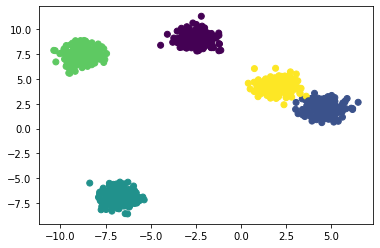

In [2]:
import numpy as np
np.random.seed(42)
X, y, centroids_true = make_blobs(
    n_samples = 1000,
    centers = 5,
    cluster_std= 0.6,
    return_centers=True
)
plt.scatter(X[:,0], X[:,1], c=y);

In [3]:
@jax.jit # good
def get_dists(X, centroids):
    """Generates distance of X from each centroid
    """
    dists = [jnp.linalg.norm((X - centroid), axis=1) for centroid in centroids]
    return jnp.array(dists)

In [4]:
@jax.jit
def clustering_loss(centroids, X):
    """Given X and centroids, calculates clustering loss
    """
    all_squared_errors = jnp.array([jnp.sum(jnp.square(X - centroid), axis=1) for centroid in centroids])
    loss = jnp.mean(jnp.min(all_squared_errors, axis=0))
    return loss

In [5]:
# not sure how to work with jax.random yet
def centroids_kmeanspp_init(X, k=5):
    """Generates k centroids using kmeans++ improved random initialization
    """
    import numpy as np
    centroids = []
    # generate first centroid randomly from X
    centroids.append(X[np.random.randint(X.shape[0]), :])
    for c_n in range(k-1):
        dists = get_dists(X, centroids)
        dists = jnp.min(dists, axis=0)
        centroids.append(X[jnp.argmax(dists), :])
    return jnp.array(centroids)

In [6]:
@jax.jit
def cluster(X, centroids):
    """Given X and centroids, returns cluster labels for each instance of X
    """
    dists = get_dists(X, centroids)
    return jnp.argmin(dists, axis=0)

In [7]:
@jax.jit
def update(cents_old, v_old, X, centroids, lr, gamma):
    """Calculates update step of momentum gradent descent
    """
    loss_val, grads =  jax.value_and_grad(clustering_loss)(centroids, X)
    return loss_val, cents_old - (gamma*v_old + lr*grads)

In [8]:
#@jax.jit ---> VERY BAD (cold start because of jitting)
def k_means_momentum_gd(X, centroids, lr, n_iter=100, gamma=0.9, rtol=1e-4):
    v = jnp.zeros_like(centroids)
    for i in tqdm(range(n_iter)):
        loss_val, centroids = update(centroids, v, X, centroids, lr, gamma)
    return loss_val, centroids

In [9]:
### VERSION 2
lr = 1
centroids_init = centroids_kmeanspp_init(X, k=5)
best_loss, best_centroids = k_means_momentum_gd(X, centroids_init, lr)
print(f'Best loss: {best_loss}')

100%|██████████| 100/100 [00:00<00:00, 541.85it/s]

Best loss: 0.6987711787223816


In [10]:
print(f'Best_loss: {best_loss} vs. actual_loss: {clustering_loss(centroids_true, X)}')

Best_loss: 0.6987711787223816 vs. actual_loss: 0.7037339210510254


In [11]:
best_labels = cluster(X, best_centroids)

In [12]:
print(f'ARI: {ARI(y, best_labels)}, AMI:{AMI(y, best_labels)}')

ARI: 0.9974962343264018, AMI:0.9960669625875374


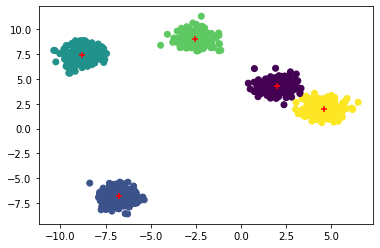

In [13]:
plt.scatter(X[:,0], X[:,1], c=best_labels);
plt.scatter(best_centroids[:,0], best_centroids[:,1], marker='+', color='red');

# Using Optax

In [14]:
def optax_clustering_loss(params, X_clustered):
    """Given X and centroids, calculates clustering loss
    """
    all_squared_errors = jnp.array([jnp.sum(jnp.square(X - centroid), axis=1) for centroid in params['centroids']])
    loss = jnp.mean(jnp.min(all_squared_errors, axis=0))
    return loss

In [15]:
def kmeans_optax(X, optimizer, n_iter=100, r_tol=1e-4, k=5):
    params = {
        'centroids': centroids_kmeanspp_init(X, k=k)
    }
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, X, k=k):
        loss, grads = jax.value_and_grad(
                optax_clustering_loss,
            )(params, X)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    for i in tqdm(range(n_iter)):
        params, opt_state, loss = step(params, opt_state, X, k=k)
    
    print(f'Best loss: {loss}')
    return params

In [16]:
optimizer = optax.adamw(learning_rate=1)
params = kmeans_optax(X, optimizer, k=5)

100%|██████████| 100/100 [00:00<00:00, 289.35it/s]

Best loss: 0.6988077163696289


In [17]:
optax_best_labels = cluster(X, params['centroids'])

In [18]:
print(f'Optax ARI: {ARI(y, optax_best_labels)}, Optax AMI:{AMI(y, optax_best_labels)}')

Optax ARI: 0.9974962343264018, Optax AMI:0.9960669625875374


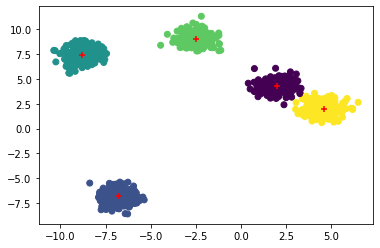

In [19]:
plt.scatter(X[:,0], X[:,1], c=optax_best_labels);
plt.scatter(params['centroids'][:,0], params['centroids'][:,1], marker='+', color='red');